In [3]:
import sys
sys.path.append("../Database/")
from STMdatabase import STMdatabase as database
from STMdatabase import STMimage,STMspec,STMgrid
from display import STMimagePlot
from os.path import join
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import math
from os import listdir,path
import pySPM
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import pandas as pd
import nanonispy as nap
import warnings
warnings.filterwarnings("ignore")

In [4]:
databaseName="../../STMdata.db"
myDir,myFolder,myFileName="../../../STMdata","20230223","SiC053.sxm"
mydatabase=database(databaseName)
myPath=join(myDir,myFolder,myFileName)

In [11]:
sql="SELECT  STMdataLists.Date  FROM STMdataLists , STMimageLabel WHERE STMdataLists.List_ID = STMimageLabel.List_ID AND STMdataLists.UpdateFilePath='{0}'".format(myPath)
Date=mydatabase.execute_sql_fetchone(sql)
sql="SELECT STMdataLists.UpdateFilePath FROM STMdataLists WHERE STMdataLists.Date= '{0}'".format(Date)
fectch=mydatabase.execute_sql_fetchall(sql)
filePaths=np.array(fectch).reshape(-1)

SUCCESS---------SELECT  STMdataLists.Date  FROM STMdataLists , STMimageLabel WHERE STMdataLists.List_ID = STMimageLabel.List_ID AND STMdataLists.UpdateFilePath='../../../STMdata/20230223/SiC053.sxm'
SUCCESS---------SELECT STMdataLists.UpdateFilePath FROM STMdataLists WHERE STMdataLists.Date= '30.03.2023'


In [12]:
def read_pointSpec(fig,ax,filePath,directory = "../STMdata/20220223",file = "001",offset=0,sigma=2):
    
    filePath=filePath
    df_h=pd.read_csv(filePath,sep="\t",nrows=15)
    #print(df_h)
    x=df_h["bias spectroscopy"][2]
    y=df_h["bias spectroscopy"][3]
    z=df_h["bias spectroscopy"][4]
    #print(x,y,z)
    

    xlabel="Sample bias (V)"
    ylabel=r"$dI/dV$ ($a.u.$)"
    Ilabel=r"$I$ ($a.u.$)"
    title=r"The waterfall of $STS$ along the cut line"
    df=pd.read_table(filePath,sep="\t",skiprows=17)
    sts_filtered=gaussian_filter(df["LIY 1 omega (A)"],sigma=sigma)
    I_filtered=gaussian_filter(df["Current (A)"],sigma=sigma)
    X=np.array(df["Bias calc (V)"])
    Y=sts_filtered*1e12+offset
    ax[0].plot(X,Y,label=ylabel)
    #ax[0].legend()
    ax[0].set_title(filePath)
    ax[1].plot(X,I_filtered*1e12,label=Ilabel)
    #ax[1].legend()
    ax[1].set_title(filePath)
    return x,y,z


def read_file_para(filePath):
    SXMfile=pySPM.SXM(filePath)
    header=SXMfile.header
    [x_n,y_n]=header['SCAN_RANGE'][0]
    Bias=header['BIAS'][0][0]
    Curr=header['Z-CONTROLLER'][1][3]
    Pos=header['SCAN_OFFSET'][0]
    return Bias,Curr,Pos,x_n


def read_grid_par(filePath):
    grid = nap.read.Grid(filePath) 
    sweep=grid._derive_sweep_signal()
    omegaYArray = grid._load_data()['LIY 1 omega (A)']
    params=grid._load_data()['params']
    head = grid.read_raw_header(byte_offset=745)
    df=pd.DataFrame([x.split(",") for x in head.split("\r\n")])
    #print(df)
    #print(df[0][0],df[0][1],df[0][8])
    Res=[j for j in df[0][0].split("=")]
    Set=[j for j in df[0][1].split(";")]
    Point=[j for j in df[0][8].split("=")]
    #print(Res)
    #print("---------")
    #print(Set)
    #print("---------")
    #print(Point)
    Resxy=[j for j in Res[1].split("x")]
    xpoints=[j for j in Set[0].split("=")]

    Resoltion=[float(Resxy[0][1:]),float(Resxy[1][:3]),float(Point[1])]
    position=[float(xpoints[1]),float(Set[1])]
    size=[float(Set[2]),float(Set[3])]

    return Resoltion,position,size

TypeError: 'AxesSubplot' object is not subscriptable

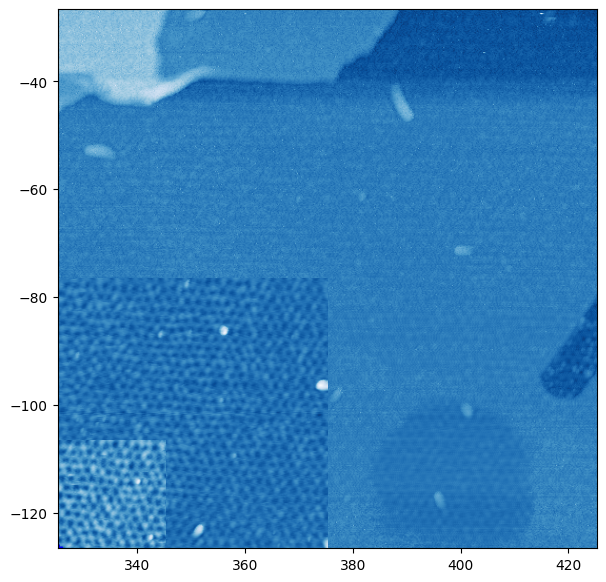

In [15]:
figs,axs=plt.subplots(1,1,figsize=(7,7))

for myfile in filePaths: 
    if myfile.endswith(".sxm"):
        SXMfile=pySPM.SXM(myfile)
        Bias,Curr,Pos,x_n=read_file_para(myfile)
        Z_image=SXMfile.get_channel('Z')
        Z_image.correct_median_diff()
        Z_image.correct_lines()
        image=Z_image.pixels
        y_n=x_n
        y_p,x_p=image.shape[1],image.shape[0]
        X=np.linspace(float(Pos[0])*1e9,float(Pos[0])*1e9+float(x_n)*1e9,int(x_p))
        Y=np.linspace(float(Pos[1])*1e9,float(Pos[1])*1e9+float(y_n)*1e9,int(y_p))
        extent=[X[0],X[-1],Y[0],Y[-1]]
        axs.imshow(image,cmap="Blues_r",extent=extent)
        axs.plot(float(Pos[0])*1e9,float(Pos[1])*1e9,"-*",color="blue")
    if myfile.endswith(".dat"):
        x,y,_=read_pointSpec(figs,axs,myfile,offset=0,sigma=2)
        axs.plot(float(x)*1e9,float(y)*1e9,"-o",color="red")
    if myfile.endswith(".3ds"):
        Resoltion,position,size=read_grid_par(myfile)
        axs.plot(float(position[0]*1e9),float(position[1]*1e9),"-x",color="gray")
                
axs.set_xlim(-700,1200)
axs.set_ylim(-1250,500)   
xlabel=r"X position(nm)"
ylabel=r"Y position(nm)"
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

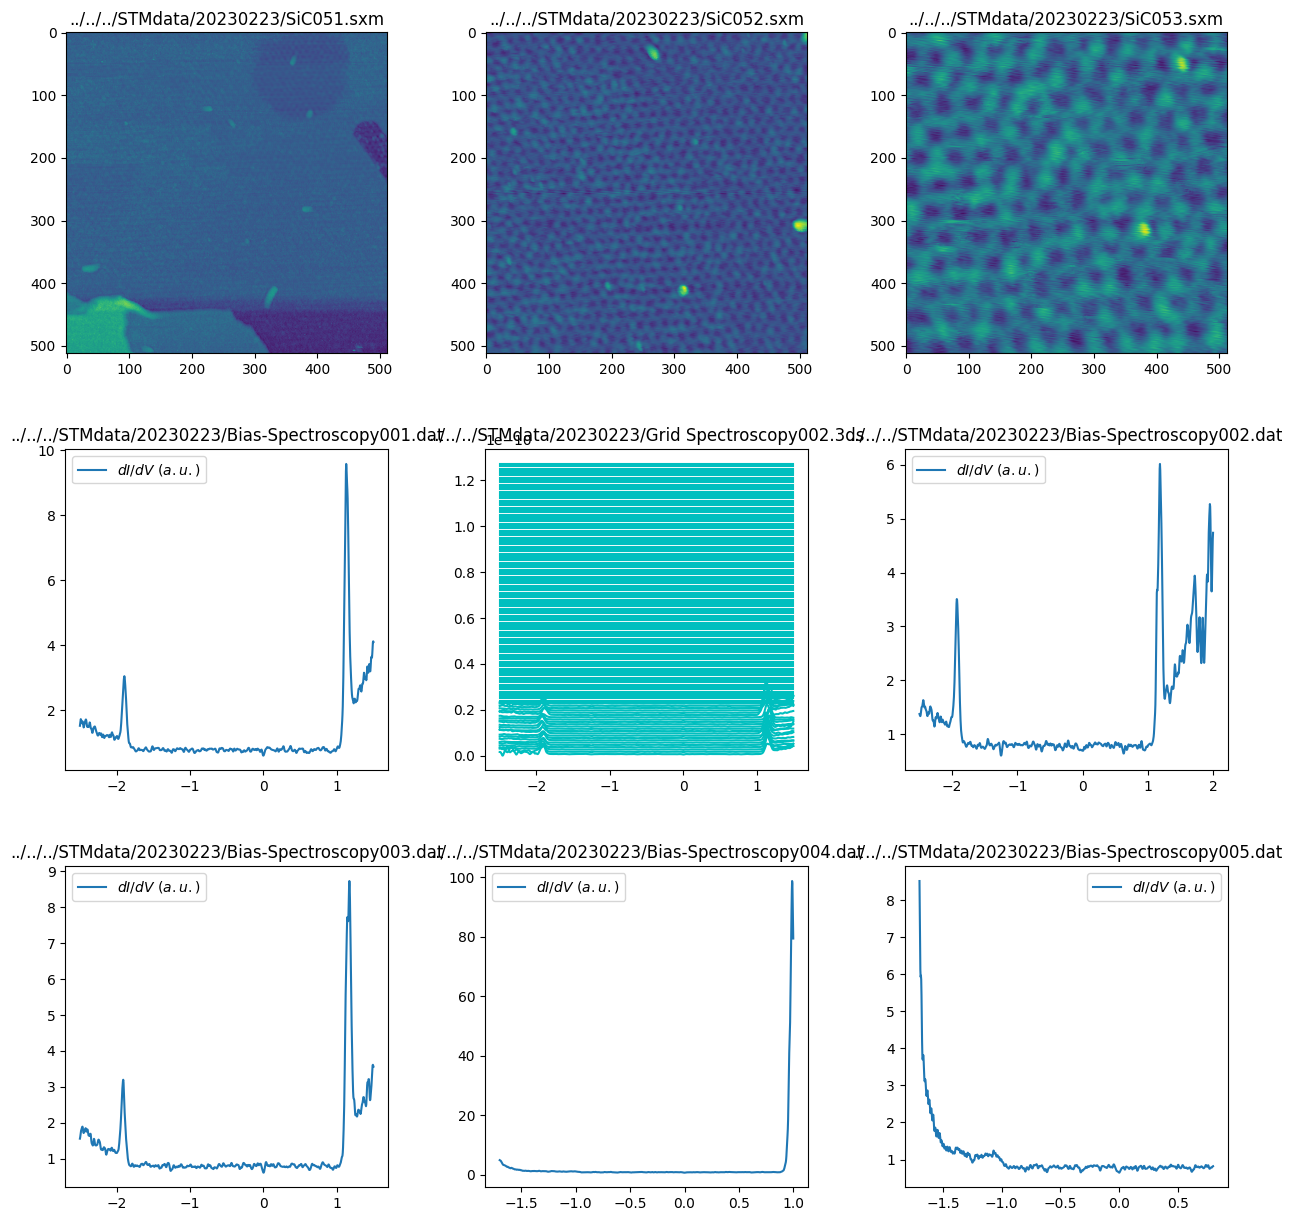

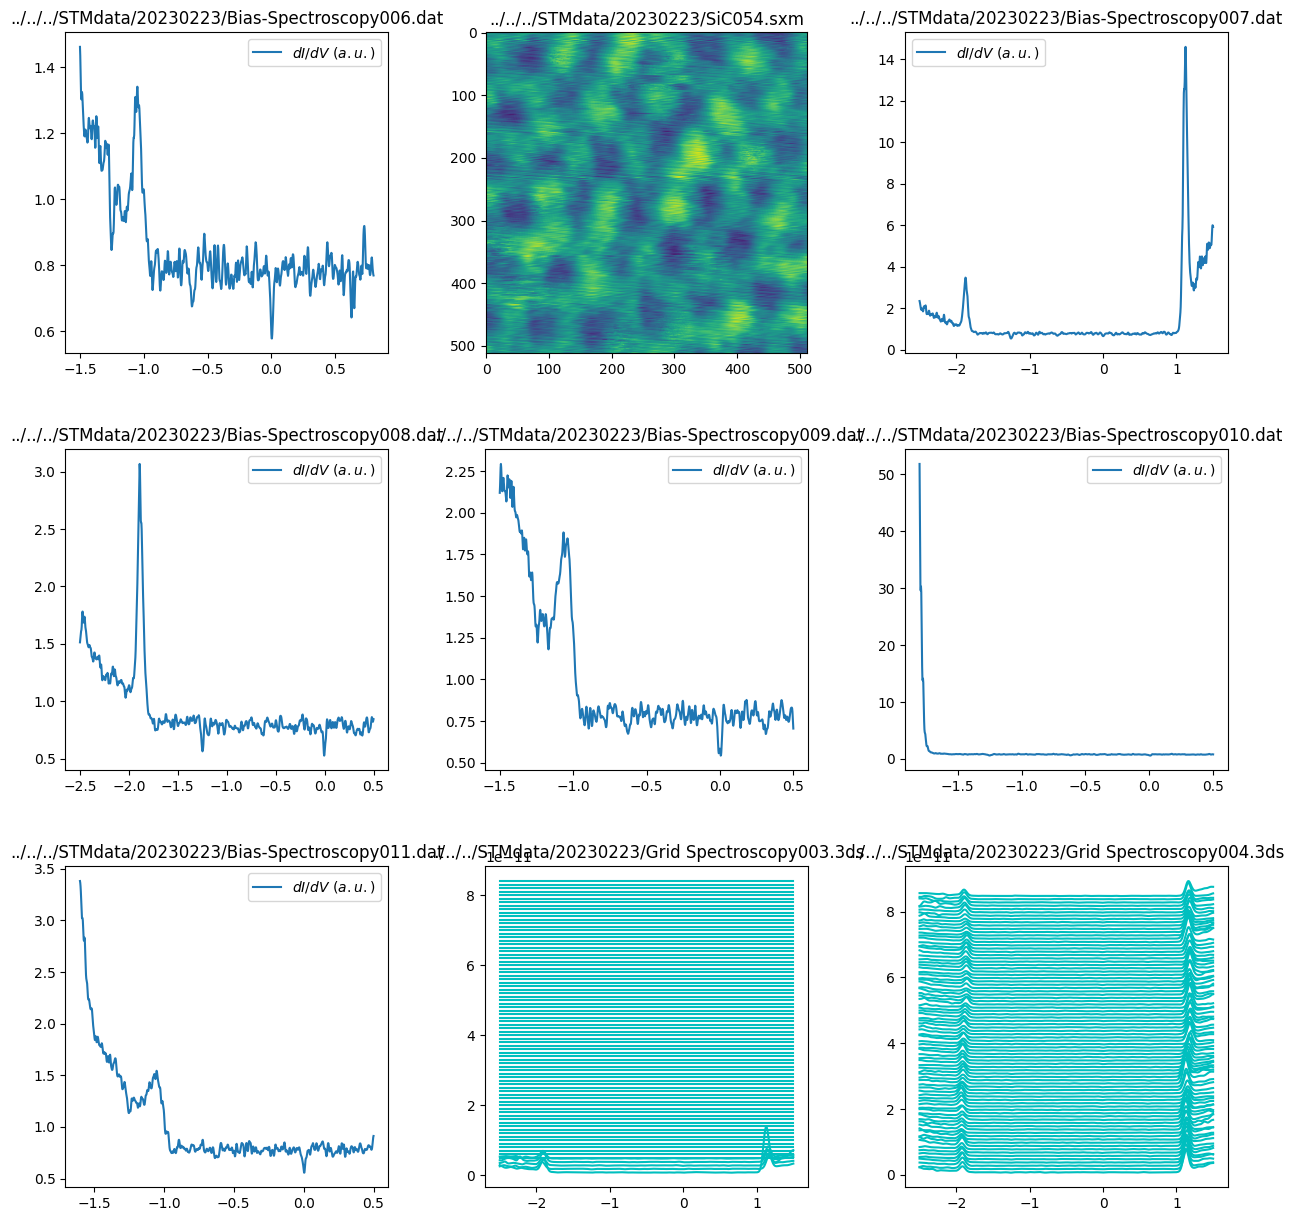

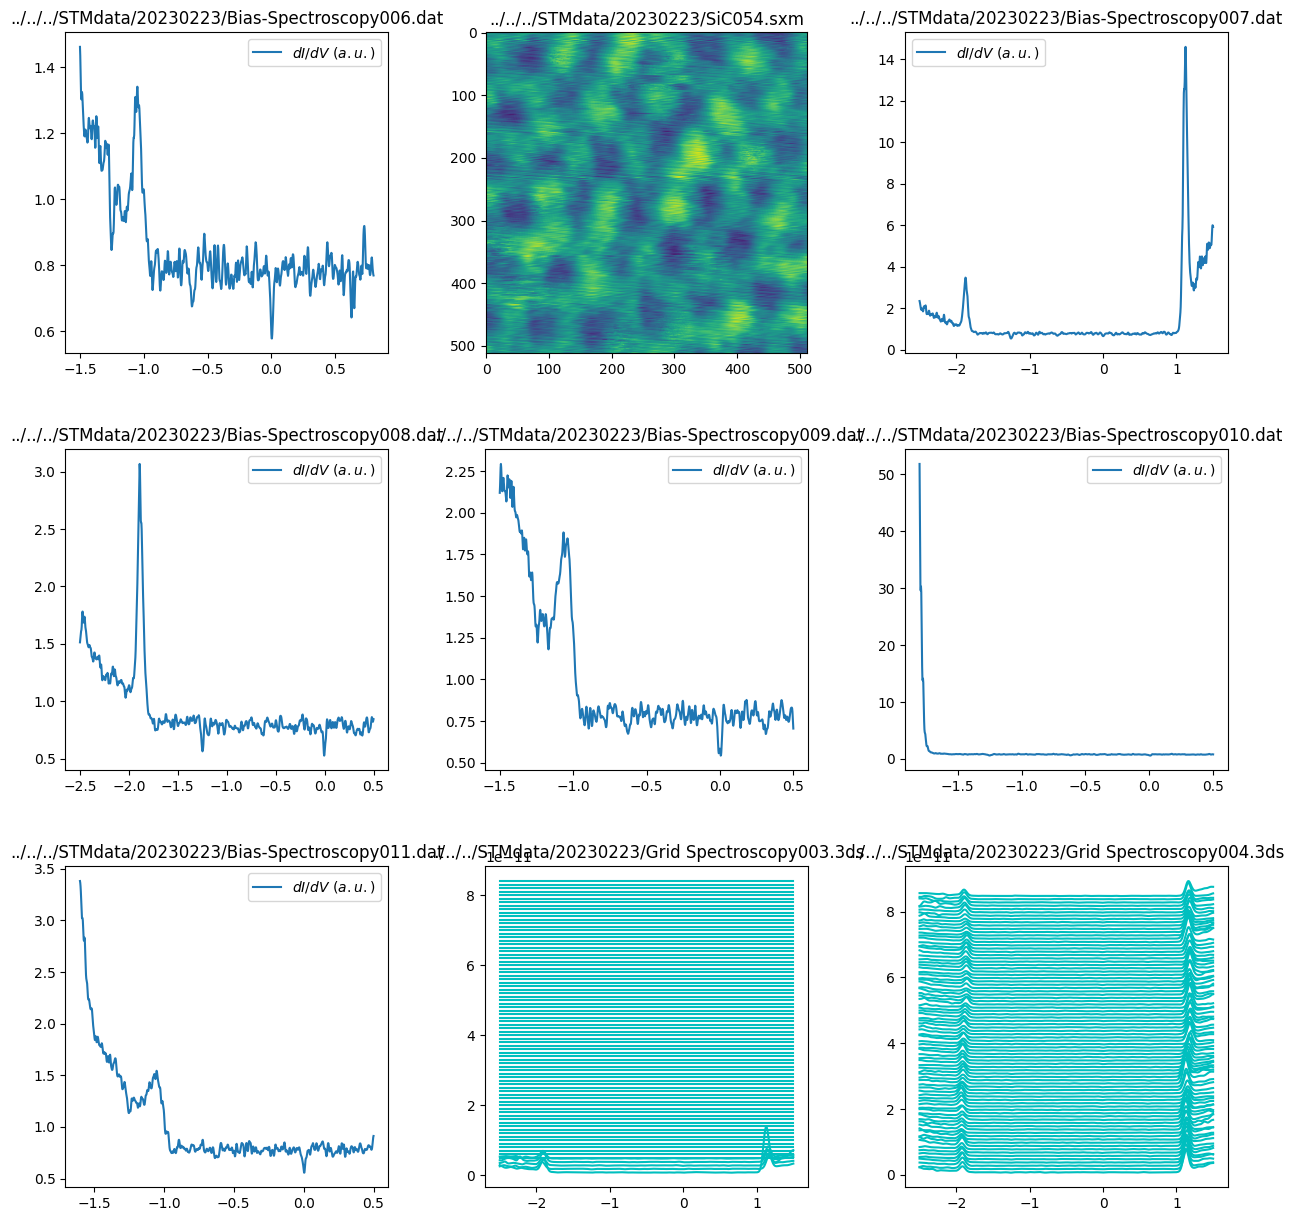

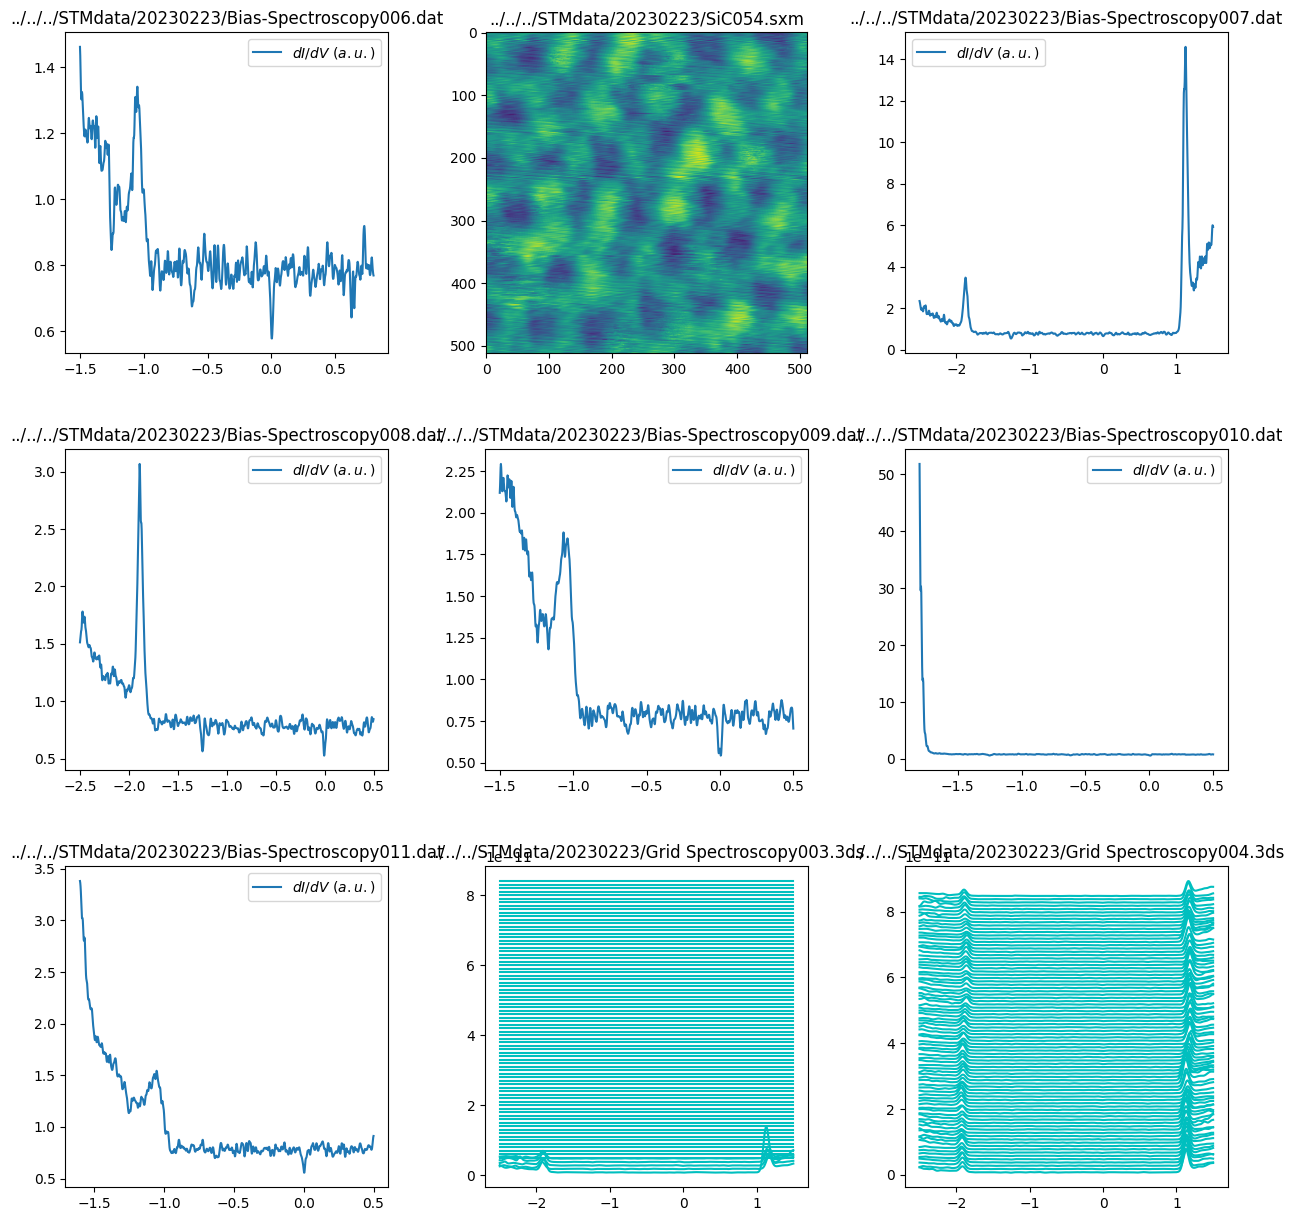

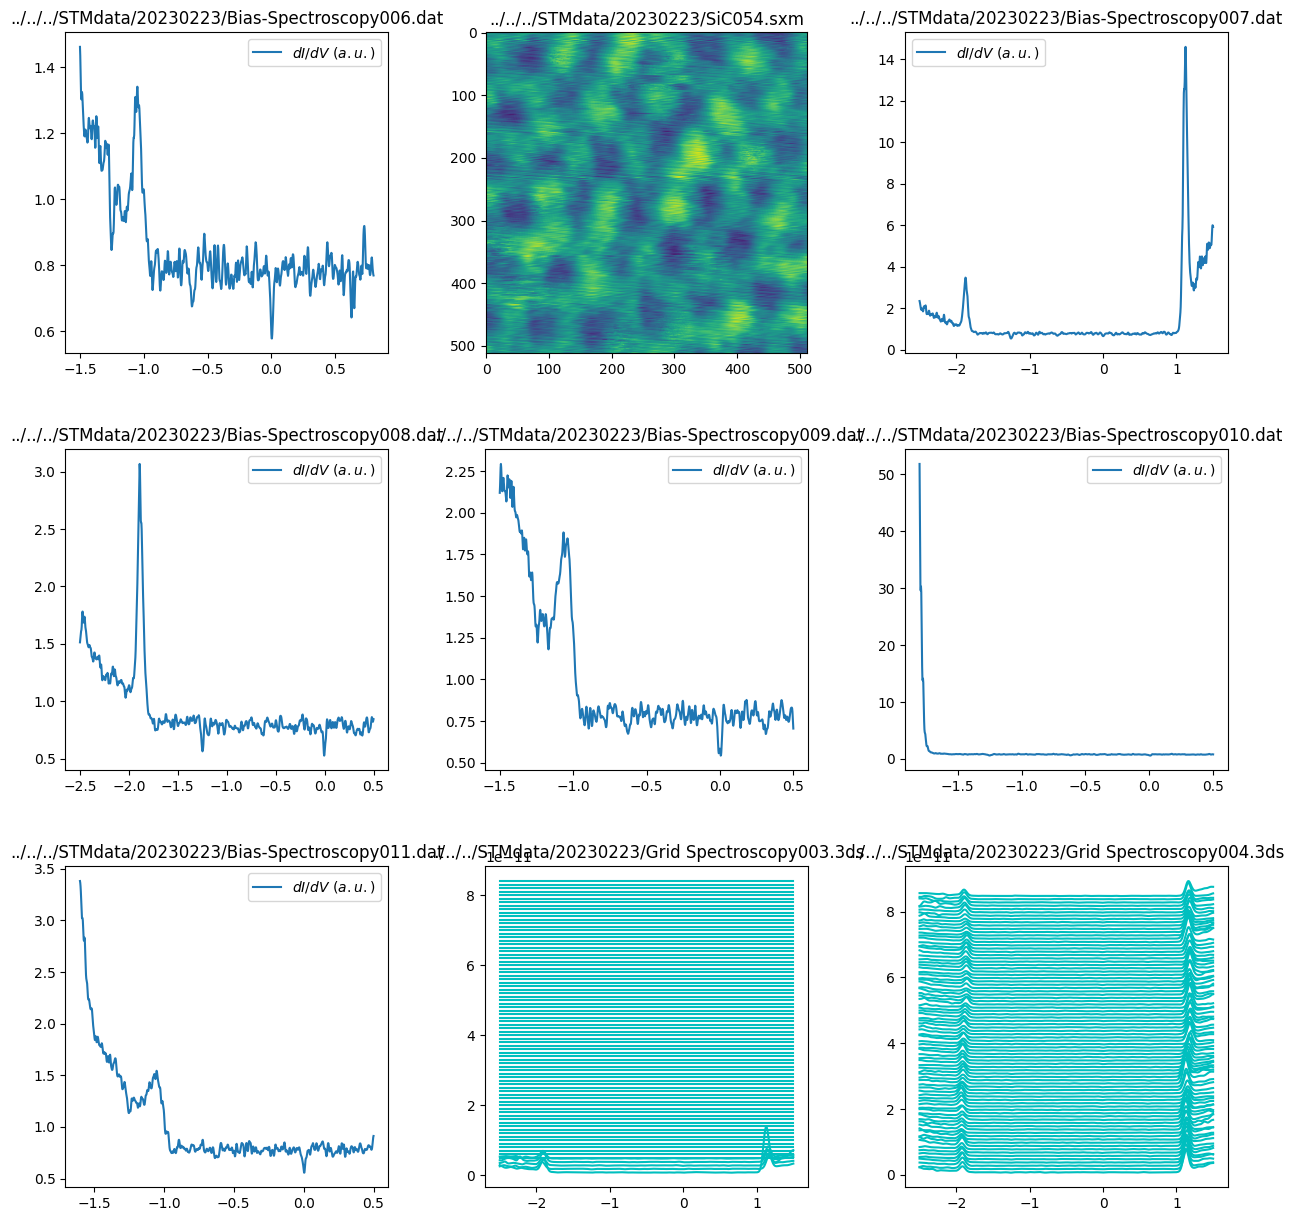

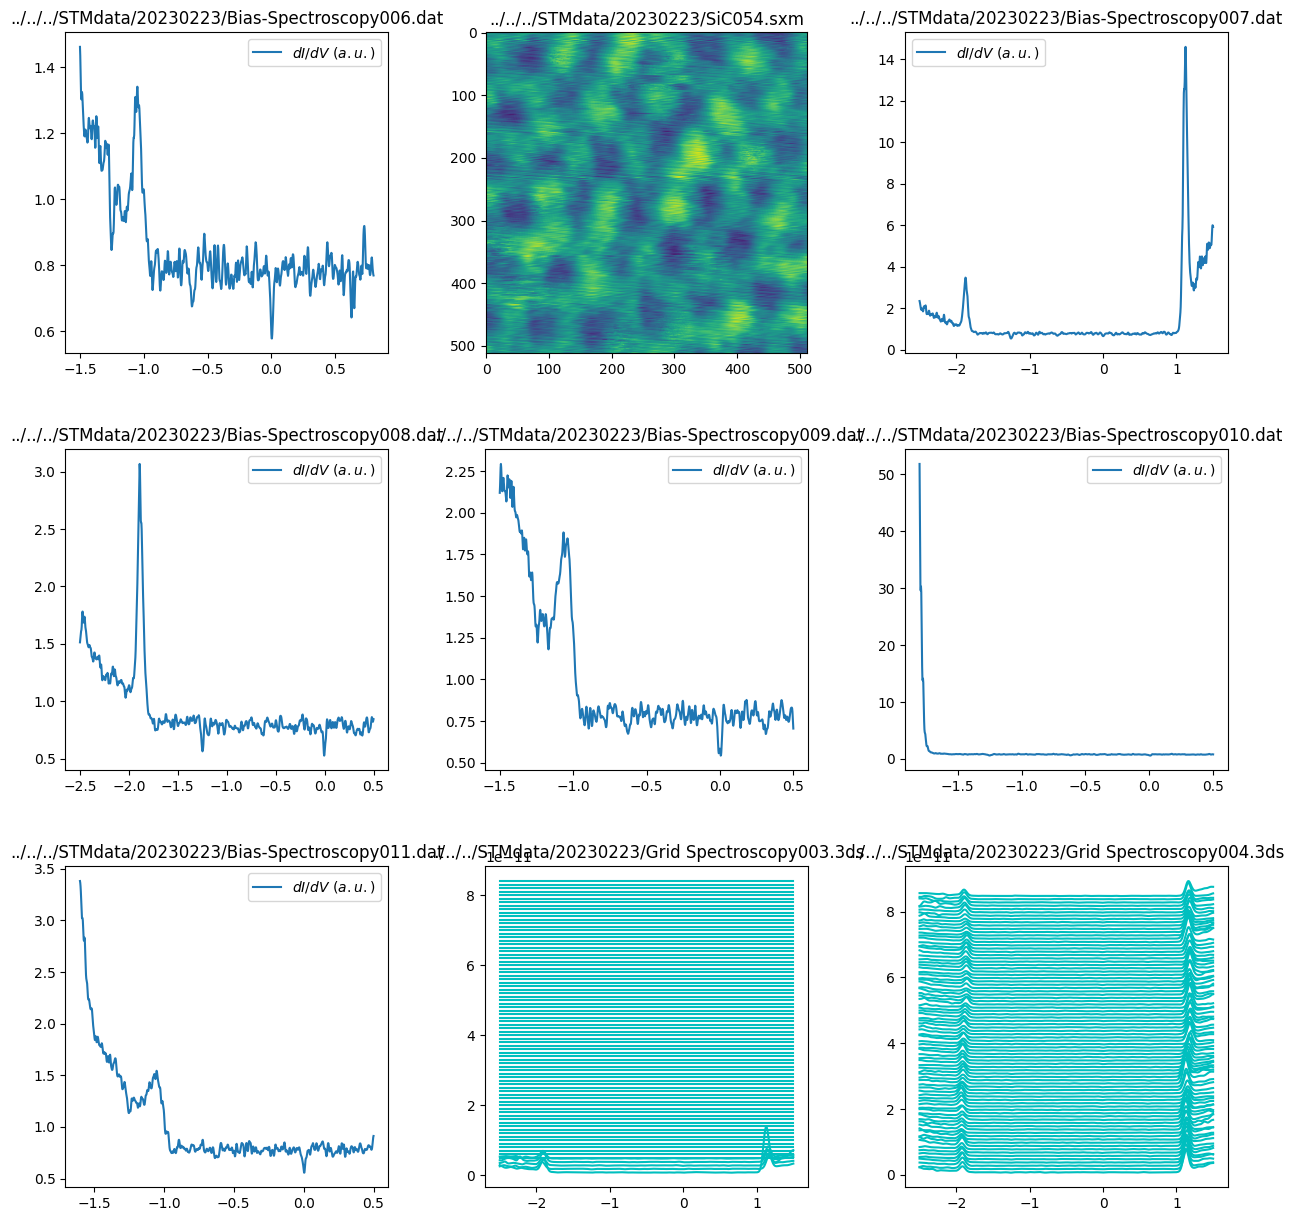

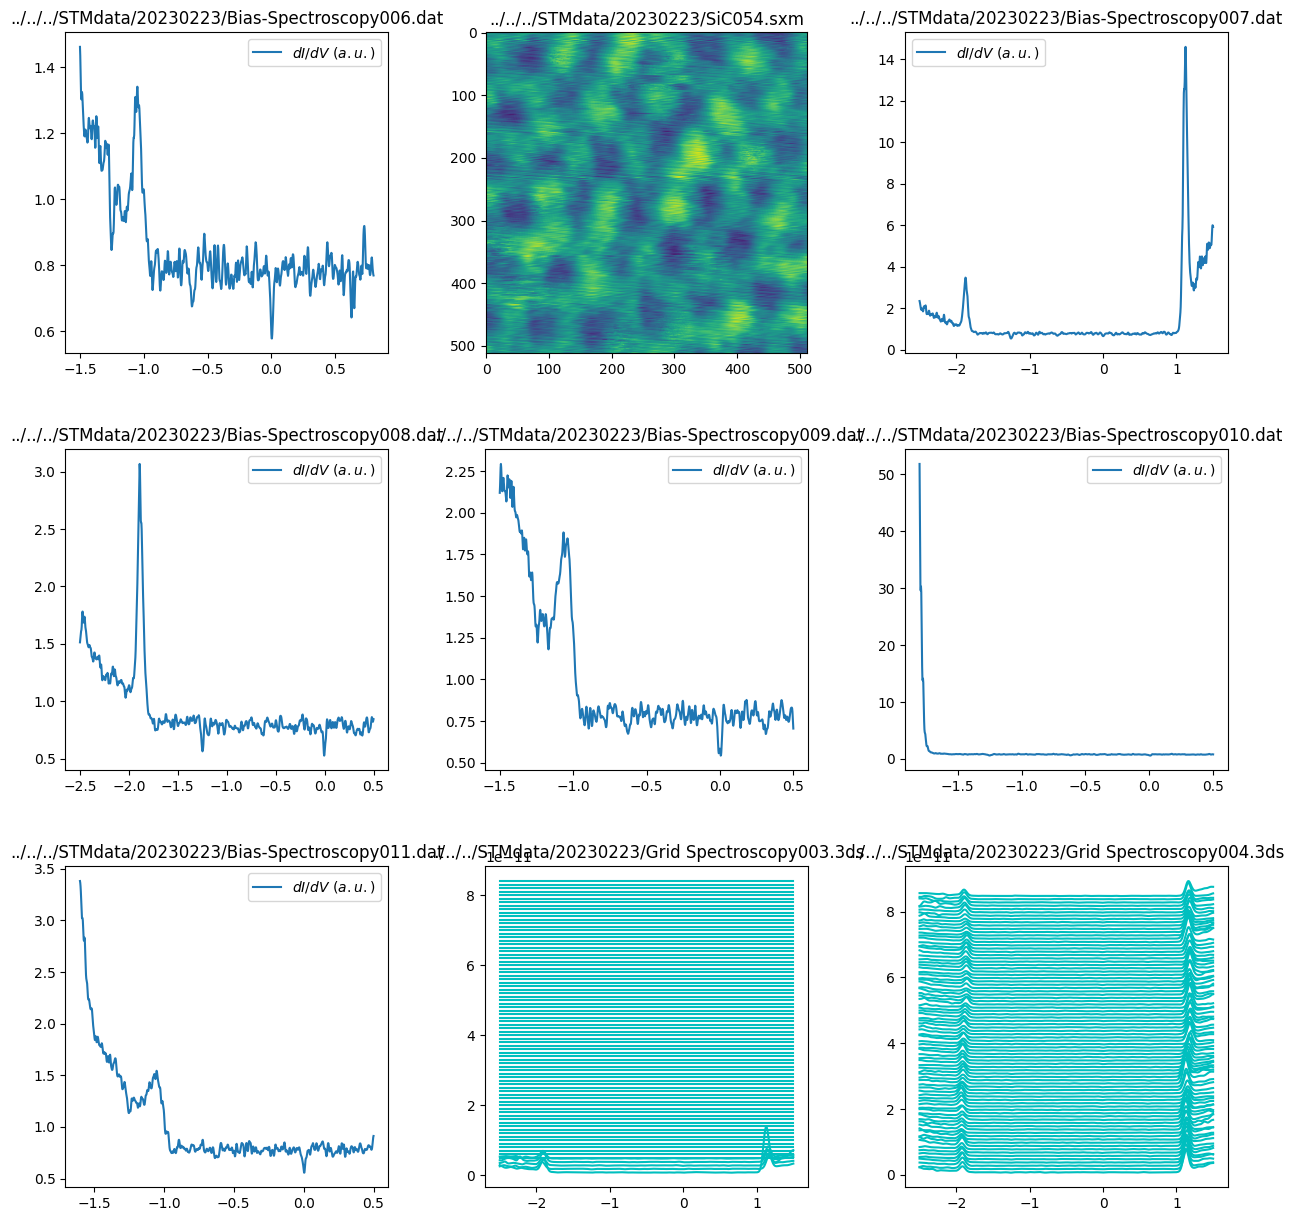

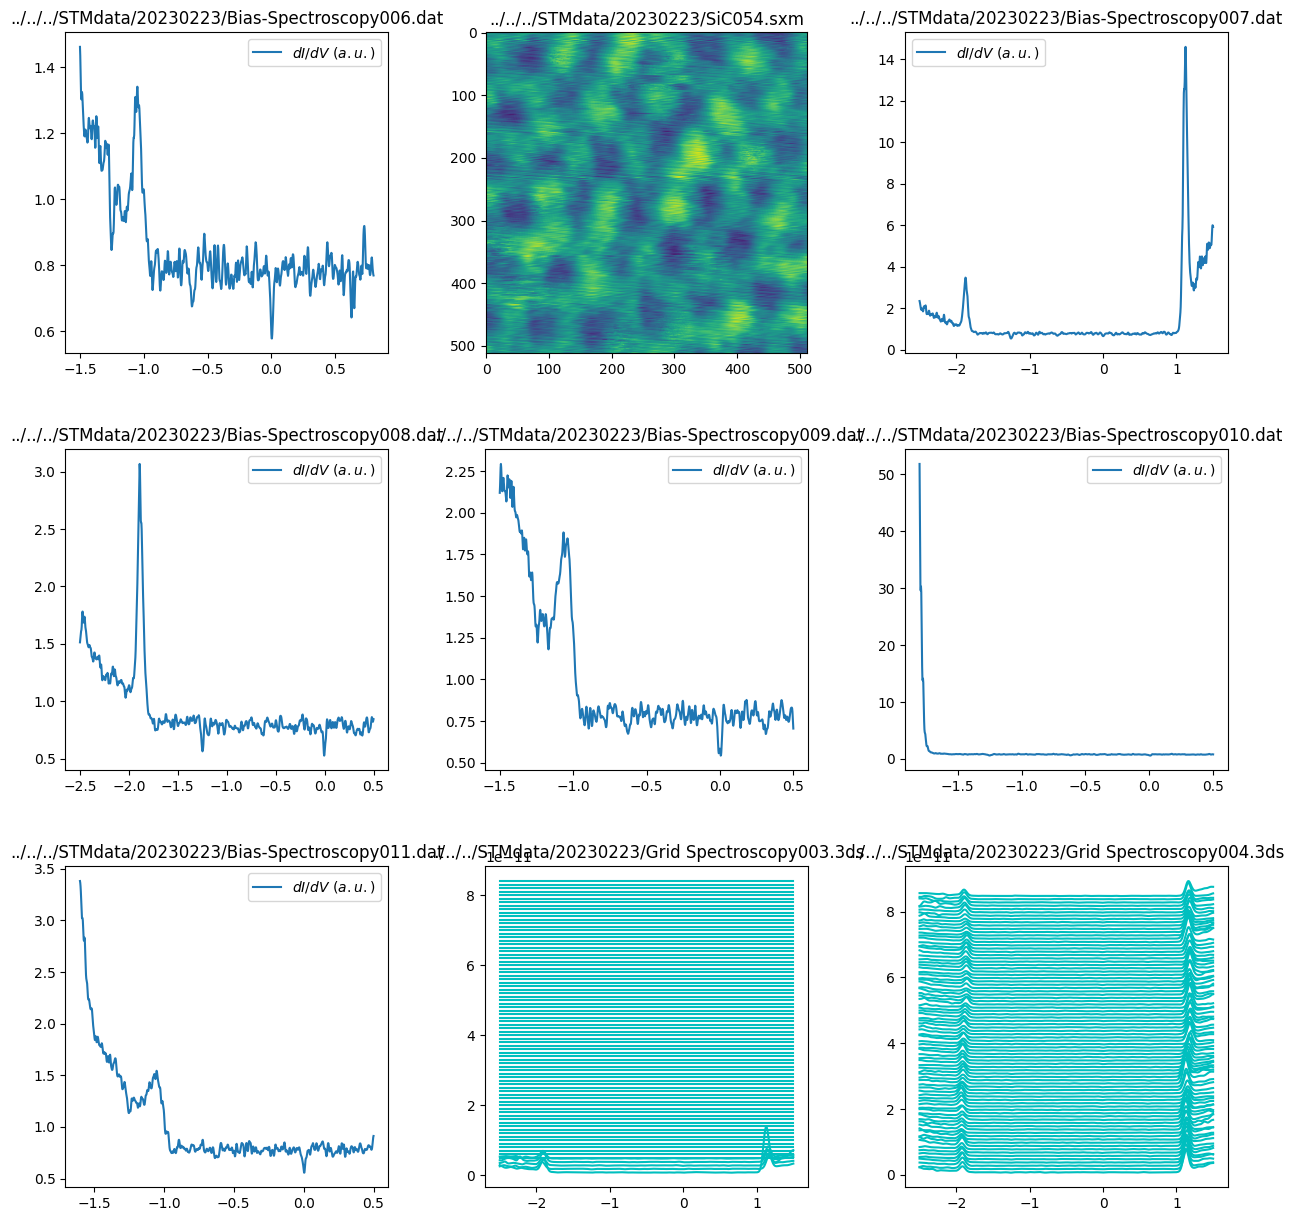

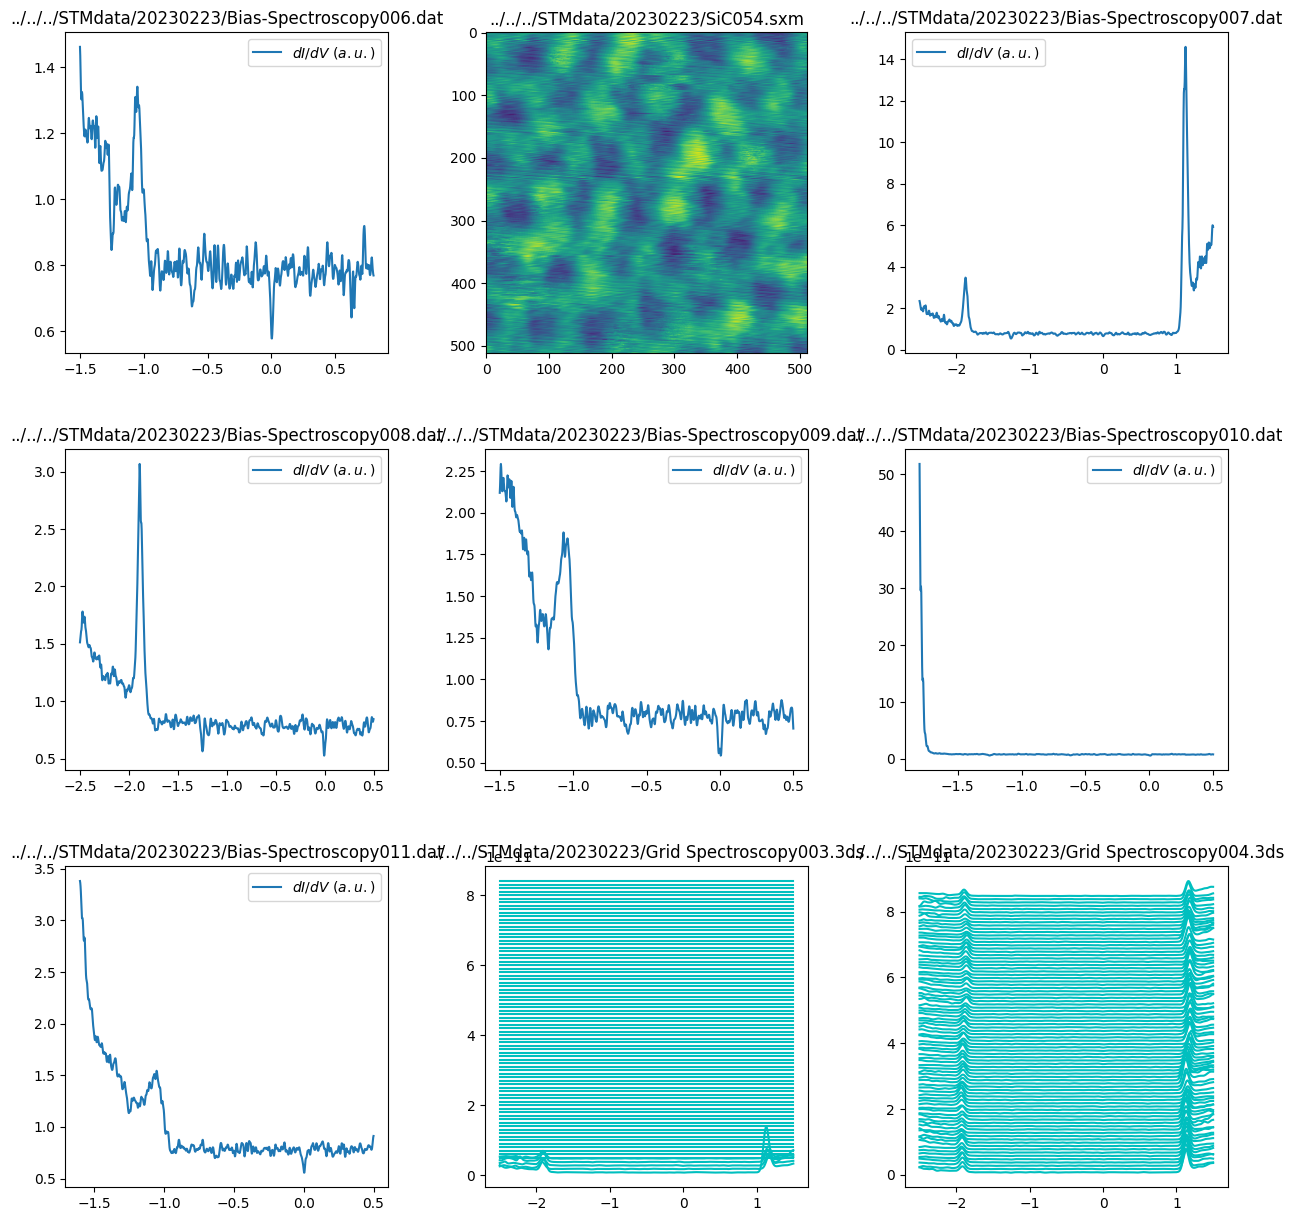

In [7]:
ZeroPath=[]
num=len(filePaths)//9
lef=len(filePaths)%9

if lef:
    for m in range((num+1)*9):
        if m < len(filePaths):
            ZeroPath.append(filePaths[m])
        else:
            ZeroPath.append(filePaths[-1])
else:
    ZeroPath=filePaths

filePaths=np.array(ZeroPath)
num=len(ZeroPath)//9
lef=len(ZeroPath)%9
filePaths=filePaths.reshape(-1,9)


for m,raw in enumerate(filePaths):
    plt.figure(figsize=[15,15])
    for i,col in enumerate(raw):
        filePath=col
        plt.subplot(3,3,i+1)

        if filePath.endswith(".sxm"):
            SXMfile=pySPM.SXM(filePath)
            Z_image=SXMfile.get_channel('Z')
            img=Z_image.pixels
            (x_p,y_p)=img.shape
            if x_p>300:
                Z_image=SXMfile.get_channel('Z')
                Z_image.correct_median_diff()
                Z_image.correct_lines()
                plt.imshow(Z_image.pixels[::-1])
                plt.title(filePath)
            else:
                try:
                    Z_image=SXMfile.get_channel('LIY_1_omega')
                    Z_image.correct_median_diff()
                    Z_image.correct_lines()
                    plt.imshow(Z_image.pixels[::-1])
                    plt.title("LIX"+filePath)
                except:
                    Z_image=SXMfile.get_channel('Z')
                    Z_image.correct_median_diff()
                    Z_image.correct_lines()
                    plt.imshow(Z_image.pixels[::-1])
                    plt.title(filePath)


        elif filePath.endswith(".dat"):
            xlabel="Sample bias (V)"
            ylabel=r"$dI/dV$ ($a.u.$)"
            title=r"The waterfall of $STS$ along the cut line"
            

            try:
                df=pd.read_table(filePath,sep="\t",skiprows=17)
                sts_filtered=gaussian_filter(df["LIY 1 omega (A)"],sigma=2)
                plt.plot(np.array(df["Bias calc (V)"]),np.array(sts_filtered*1e12+offset),label=ylabel)
                plt.legend()
                plt.title(filePath)
            except:
                try:
                    df=pd.read_table(filePath,sep="\t",skiprows=17)
                    sts_filtered=gaussian_filter(df["LIX 1 omega (A)"],sigma=2)
                    plt.plot(np.array(df["Bias calc (V)"]),np.array(sts_filtered*1e12+offset),label=ylabel)
                    plt.legend()
                    plt.title(filePath)
                except:
                    df=pd.read_table(filePath,sep="\t",skiprows=17)
                    print(df.head)
            finally:
                pass

        elif filePath.endswith(".3ds"):
            try:
                grid = nap.read.Grid(filePath) 
                sweep=grid._derive_sweep_signal()
                omegaYArray = grid._load_data()['LIY 1 omega (A)']
                params=grid._load_data()['params'] 
                raw=omegaYArray[0]
                xlabel="Sample bias (V)"
                ylabel=r"$dI/dV$ ($a.u.$)"
                title=r"The waterfall of $STS$ along the cut line"
                step=(sweep[-1]-sweep[0])/raw.shape[1]
                offset=1e-12
                unit=1
                plt.title(filePath)
                for j,cole in enumerate(raw):
                    raw_data = cole
                    raw_filted=gaussian_filter(raw_data, sigma=3)
                    plt.plot(sweep,(raw_filted+offset*j)*unit,color="c")
            except:
                pass

    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()